In [1]:
!pip install xgboost
!pip install utils
import warnings
warnings.filterwarnings("ignore")
import argparse
import pickle
import numpy as np
import pandas as pd
import sys
import itertools
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc, accuracy_score, confusion_matrix, roc_curve, precision_score, recall_score, f1_score
from utils import *

# Keras+Tensorflow libraries
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adadelta
from keras.wrappers.scikit_learn import KerasClassifier
#from keras.layers.normalization import BatchNormalization
from keras import callbacks
from tensorflow.keras.layers import BatchNormalization
# Config Keras
num_cores = 8
GPU = True
CPU = False

if GPU:
    num_GPU = 1
    num_CPU = 1
if CPU:
    num_CPU = 1
    num_GPU = 0

config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
tf.compat.v1.keras.backend.set_session(session)
#session = tf.compat.v1.keras.backend.set_session(graph=tf.compat.v1.get_default_graph(), config=config)

In [2]:
PFeaturebladder=pd.read_csv('bladder_features.csv')
Labelbladder=pd.read_csv('bladder_training_genes_set.csv')

In [3]:
PFeaturebladder=PFeaturebladder.drop(columns = 'Unnamed: 0')

In [4]:
PFeaturebladder

,id,gene,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,x_25,x_26,x_27,x_28,x_29,x_30,x_31,essentiality,mutation,expression
0,777,A2ML1,-0.311149,-0.143030,0.806850,0.266194,0.257400,0.798550,0.809984,-0.121977,...,0.240906,-0.855502,0.531886,0.935358,0.598545,0.250591,-0.111853,0.081894,0.025813,1.97
1,925,ABAT,-0.489597,-0.237806,-0.463712,0.464785,0.104225,0.489648,-0.764656,-0.445883,...,-0.263741,-1.031566,0.423038,0.368492,0.820006,0.812067,0.338338,-0.079815,0.009117,8.76
2,8898,ACRBP,0.855856,0.575842,0.693906,0.372863,0.713353,0.188507,-0.706515,-0.035103,...,0.140048,-0.477542,0.157696,0.620279,0.614918,1.288987,-0.528507,-0.002749,0.007799,4.93
3,5345,ADCY6,-0.170932,-0.477850,0.335727,1.079902,0.498655,0.067576,-0.397581,-0.672067,...,0.407690,-0.360535,-0.452117,0.764156,0.689644,-0.323331,0.737307,0.058840,0.014609,10.23
4,9314,ADCY8,-0.390826,0.063613,0.749340,1.701074,-0.058437,0.024931,-0.255330,-1.184387,...,-0.053215,-0.088711,-0.975930,0.196550,1.050285,-0.273918,0.815563,0.008544,0.039104,0.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,639,ZNF606,0.297573,-0.265292,0.289673,0.657997,0.537086,-0.089884,-0.884699,0.286783,...,0.183318,-0.715323,0.969468,0.237033,0.790892,-0.947310,0.269935,-0.107006,0.013620,7.96
407,11814,ZNF628,0.381664,-0.087722,-0.405289,0.739695,0.135660,0.079073,-0.631562,-0.536984,...,0.253680,-0.618612,0.755584,1.297709,1.304174,1.341915,0.267396,0.010298,0.008678,7.41
408,4541,ZNF639,0.400007,0.276891,0.740922,0.352265,-0.218725,0.231702,0.308993,-0.687320,...,0.423389,-0.181542,0.333157,0.291352,1.097359,-0.027141,0.694962,-0.028824,0.007359,9.21
409,6844,ZNF75A,-0.070724,0.161441,0.126041,0.330394,-0.158935,-0.371569,0.037258,-0.936996,...,0.973909,-0.867874,0.222146,-0.188817,0.958795,-0.446689,0.849425,-0.182299,0.005822,8.08


In [5]:
Labelbladder

,gene,label
0,TOP2A,positive
1,POLA1,positive
2,MDM4,positive
3,TUBB8,positive
4,TUBB2B,positive
...,...,...
446,ITPKA,negative
447,CCDC110,negative
448,SPINK6,negative
449,BAK1,negative


In [6]:
Featurebladder=PFeaturebladder.merge(Labelbladder, how='inner', on='gene')
Featurebladder

,id,gene,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,x_26,x_27,x_28,x_29,x_30,x_31,essentiality,mutation,expression,label
0,777,A2ML1,-0.311149,-0.143030,0.806850,0.266194,0.257400,0.798550,0.809984,-0.121977,...,-0.855502,0.531886,0.935358,0.598545,0.250591,-0.111853,0.081894,0.025813,1.97,negative
1,925,ABAT,-0.489597,-0.237806,-0.463712,0.464785,0.104225,0.489648,-0.764656,-0.445883,...,-1.031566,0.423038,0.368492,0.820006,0.812067,0.338338,-0.079815,0.009117,8.76,negative
2,8898,ACRBP,0.855856,0.575842,0.693906,0.372863,0.713353,0.188507,-0.706515,-0.035103,...,-0.477542,0.157696,0.620279,0.614918,1.288987,-0.528507,-0.002749,0.007799,4.93,negative
3,5345,ADCY6,-0.170932,-0.477850,0.335727,1.079902,0.498655,0.067576,-0.397581,-0.672067,...,-0.360535,-0.452117,0.764156,0.689644,-0.323331,0.737307,0.058840,0.014609,10.23,negative
4,9314,ADCY8,-0.390826,0.063613,0.749340,1.701074,-0.058437,0.024931,-0.255330,-1.184387,...,-0.088711,-0.975930,0.196550,1.050285,-0.273918,0.815563,0.008544,0.039104,0.51,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,639,ZNF606,0.297573,-0.265292,0.289673,0.657997,0.537086,-0.089884,-0.884699,0.286783,...,-0.715323,0.969468,0.237033,0.790892,-0.947310,0.269935,-0.107006,0.013620,7.96,negative
407,11814,ZNF628,0.381664,-0.087722,-0.405289,0.739695,0.135660,0.079073,-0.631562,-0.536984,...,-0.618612,0.755584,1.297709,1.304174,1.341915,0.267396,0.010298,0.008678,7.41,negative
408,4541,ZNF639,0.400007,0.276891,0.740922,0.352265,-0.218725,0.231702,0.308993,-0.687320,...,-0.181542,0.333157,0.291352,1.097359,-0.027141,0.694962,-0.028824,0.007359,9.21,negative
409,6844,ZNF75A,-0.070724,0.161441,0.126041,0.330394,-0.158935,-0.371569,0.037258,-0.936996,...,-0.867874,0.222146,-0.188817,0.958795,-0.446689,0.849425,-0.182299,0.005822,8.08,negative


In [7]:
Featurebladder['label'].value_counts()

negative    373
positive     38
Name: label, dtype: int64

In [8]:
DropFeaturebladder=Featurebladder.drop(columns=['label'])
DropFeaturebladder

,id,gene,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,x_25,x_26,x_27,x_28,x_29,x_30,x_31,essentiality,mutation,expression
0,777,A2ML1,-0.311149,-0.143030,0.806850,0.266194,0.257400,0.798550,0.809984,-0.121977,...,0.240906,-0.855502,0.531886,0.935358,0.598545,0.250591,-0.111853,0.081894,0.025813,1.97
1,925,ABAT,-0.489597,-0.237806,-0.463712,0.464785,0.104225,0.489648,-0.764656,-0.445883,...,-0.263741,-1.031566,0.423038,0.368492,0.820006,0.812067,0.338338,-0.079815,0.009117,8.76
2,8898,ACRBP,0.855856,0.575842,0.693906,0.372863,0.713353,0.188507,-0.706515,-0.035103,...,0.140048,-0.477542,0.157696,0.620279,0.614918,1.288987,-0.528507,-0.002749,0.007799,4.93
3,5345,ADCY6,-0.170932,-0.477850,0.335727,1.079902,0.498655,0.067576,-0.397581,-0.672067,...,0.407690,-0.360535,-0.452117,0.764156,0.689644,-0.323331,0.737307,0.058840,0.014609,10.23
4,9314,ADCY8,-0.390826,0.063613,0.749340,1.701074,-0.058437,0.024931,-0.255330,-1.184387,...,-0.053215,-0.088711,-0.975930,0.196550,1.050285,-0.273918,0.815563,0.008544,0.039104,0.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,639,ZNF606,0.297573,-0.265292,0.289673,0.657997,0.537086,-0.089884,-0.884699,0.286783,...,0.183318,-0.715323,0.969468,0.237033,0.790892,-0.947310,0.269935,-0.107006,0.013620,7.96
407,11814,ZNF628,0.381664,-0.087722,-0.405289,0.739695,0.135660,0.079073,-0.631562,-0.536984,...,0.253680,-0.618612,0.755584,1.297709,1.304174,1.341915,0.267396,0.010298,0.008678,7.41
408,4541,ZNF639,0.400007,0.276891,0.740922,0.352265,-0.218725,0.231702,0.308993,-0.687320,...,0.423389,-0.181542,0.333157,0.291352,1.097359,-0.027141,0.694962,-0.028824,0.007359,9.21
409,6844,ZNF75A,-0.070724,0.161441,0.126041,0.330394,-0.158935,-0.371569,0.037258,-0.936996,...,0.973909,-0.867874,0.222146,-0.188817,0.958795,-0.446689,0.849425,-0.182299,0.005822,8.08


In [9]:
Cleanedbladder=DropFeaturebladder.drop(columns=['id', 'gene'])
Cleanedbladder

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_25,x_26,x_27,x_28,x_29,x_30,x_31,essentiality,mutation,expression
0,-0.311149,-0.143030,0.806850,0.266194,0.257400,0.798550,0.809984,-0.121977,0.755977,0.540546,...,0.240906,-0.855502,0.531886,0.935358,0.598545,0.250591,-0.111853,0.081894,0.025813,1.97
1,-0.489597,-0.237806,-0.463712,0.464785,0.104225,0.489648,-0.764656,-0.445883,-0.142962,0.423108,...,-0.263741,-1.031566,0.423038,0.368492,0.820006,0.812067,0.338338,-0.079815,0.009117,8.76
2,0.855856,0.575842,0.693906,0.372863,0.713353,0.188507,-0.706515,-0.035103,-0.303131,-0.436382,...,0.140048,-0.477542,0.157696,0.620279,0.614918,1.288987,-0.528507,-0.002749,0.007799,4.93
3,-0.170932,-0.477850,0.335727,1.079902,0.498655,0.067576,-0.397581,-0.672067,0.354475,0.364552,...,0.407690,-0.360535,-0.452117,0.764156,0.689644,-0.323331,0.737307,0.058840,0.014609,10.23
4,-0.390826,0.063613,0.749340,1.701074,-0.058437,0.024931,-0.255330,-1.184387,0.149720,0.530475,...,-0.053215,-0.088711,-0.975930,0.196550,1.050285,-0.273918,0.815563,0.008544,0.039104,0.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,0.297573,-0.265292,0.289673,0.657997,0.537086,-0.089884,-0.884699,0.286783,-0.327919,0.137784,...,0.183318,-0.715323,0.969468,0.237033,0.790892,-0.947310,0.269935,-0.107006,0.013620,7.96
407,0.381664,-0.087722,-0.405289,0.739695,0.135660,0.079073,-0.631562,-0.536984,0.306182,0.114432,...,0.253680,-0.618612,0.755584,1.297709,1.304174,1.341915,0.267396,0.010298,0.008678,7.41
408,0.400007,0.276891,0.740922,0.352265,-0.218725,0.231702,0.308993,-0.687320,0.540495,0.262434,...,0.423389,-0.181542,0.333157,0.291352,1.097359,-0.027141,0.694962,-0.028824,0.007359,9.21
409,-0.070724,0.161441,0.126041,0.330394,-0.158935,-0.371569,0.037258,-0.936996,0.913137,-0.017893,...,0.973909,-0.867874,0.222146,-0.188817,0.958795,-0.446689,0.849425,-0.182299,0.005822,8.08


In [10]:
Labelbladder=Featurebladder.label
Labelbladder

0      negative
1      negative
2      negative
3      negative
4      negative
         ...   
406    negative
407    negative
408    negative
409    negative
410    negative
Name: label, Length: 411, dtype: object

In [31]:
Labelbladder.loc[Labelbladder == 'negative'] = -1
Labelbladder.loc[Labelbladder == 'positive'] = 1

In [32]:
Labelblad = Labelbladder.astype('int')

In [33]:
Labelblad

0     -1
1     -1
2     -1
3     -1
4     -1
      ..
406   -1
407   -1
408   -1
409   -1
410   -1
Name: label, Length: 411, dtype: int32

In [34]:
X_train, X_test, y_train, y_test = train_test_split(Cleanedbladder, Labelblad, test_size=0.33, random_state=42)

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
clf = LogisticRegression(random_state=42).fit(X_train, y_train)

In [37]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [38]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

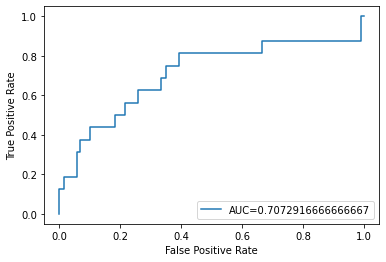

In [39]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [45]:
P_FeatureB2=pd.read_csv('breast_features.csv')
LabelB2=pd.read_csv('breast_training_genes_set.csv')

P_FeatureC=pd.read_csv('colon_features.csv')
LabelC=pd.read_csv('colon_training_genes_set.csv')

P_FeatureK=pd.read_csv('kidney_features.csv')
LabelK=pd.read_csv('kidney_training_genes_set.csv')

P_FeatureL1=pd.read_csv('leukemia_features.csv')
LabelL1=pd.read_csv('leukemia_training_genes_set.csv')

P_FeatureL2=pd.read_csv('liver_features.csv')
LabelL2=pd.read_csv('liver_training_genes_set.csv')

P_FeatureL3=pd.read_csv('lung_features.csv')
LabelL3=pd.read_csv('lung_training_genes_set.csv')

P_FeatureO=pd.read_csv('ovarian_features.csv')
LabelO=pd.read_csv('ovarian_training_genes_set.csv')

P_FeatureP=pd.read_csv('pancreatic_features.csv')
LabelP=pd.read_csv('pancreatic_training_genes_set.csv')

In [46]:
PFeatureB2=P_FeatureB2.drop(columns = 'Unnamed: 0')

PFeatureC=P_FeatureC.drop(columns = 'Unnamed: 0')

PFeatureK=P_FeatureK.drop(columns = 'Unnamed: 0')

PFeatureL1=P_FeatureL1.drop(columns = 'Unnamed: 0')

PFeatureL2=P_FeatureL2.drop(columns = 'Unnamed: 0')

PFeatureL3=P_FeatureL3.drop(columns = 'Unnamed: 0')

PFeatureO=P_FeatureO.drop(columns = 'Unnamed: 0')

PFeatureP=P_FeatureP.drop(columns = 'Unnamed: 0')

In [47]:
FeatureB2=PFeatureB2.merge(LabelB2, how='inner', on='gene')

FeatureC=PFeatureC.merge(LabelC, how='inner', on='gene')

FeatureK=PFeatureK.merge(LabelK, how='inner', on='gene')

FeatureL1=PFeatureL1.merge(LabelL1, how='inner', on='gene')

FeatureL2=PFeatureL2.merge(LabelL2, how='inner', on='gene')

FeatureL3=PFeatureL3.merge(LabelL3, how='inner', on='gene')

FeatureO=PFeatureO.merge(LabelO, how='inner', on='gene')

FeatureP=PFeatureP.merge(LabelP, how='inner', on='gene')

In [48]:
CB2=FeatureB2.drop(columns=['label', 'id', 'gene'])
CC=FeatureC.drop(columns=['label', 'id', 'gene'])
CK=FeatureK.drop(columns=['label', 'id', 'gene'])
CL1=FeatureL1.drop(columns=['label', 'id', 'gene'])
CL2=FeatureL2.drop(columns=['label', 'id', 'gene'])
CL3=FeatureL3.drop(columns=['label', 'id', 'gene'])
CO=FeatureO.drop(columns=['label', 'id', 'gene'])
CP=FeatureP.drop(columns=['label', 'id', 'gene'])

In [55]:
L_B2=FeatureB2.label
L_B2.loc[L_B2 == 'negative'] = -1
L_B2.loc[L_B2 == 'positive'] = 1
LB2 = L_B2.astype('int')

L_C=FeatureC.label
L_C.loc[L_C == 'negative'] = -1
L_C.loc[L_C == 'positive'] = 1
LC = L_C.astype('int')

L_K=FeatureK.label
L_K.loc[L_K == 'negative'] = -1
L_K.loc[L_K == 'positive'] = 1
LK = L_K.astype('int')

L_L1=FeatureL1.label
L_L1.loc[L_L1 == 'negative'] = -1
L_L1.loc[L_L1 == 'positive'] = 1
LL1 = L_L1.astype('int')

L_L2=FeatureL2.label
L_L2.loc[L_L2 == 'negative'] = -1
L_L2.loc[L_L2 == 'positive'] = 1
LL2 = L_L2.astype('int')

L_L3=FeatureL3.label
L_L3.loc[L_L3 == 'negative'] = -1
L_L3.loc[L_L3 == 'positive'] = 1
LL3 = L_L3.astype('int')

L_O=FeatureO.label
L_O.loc[L_O == 'negative'] = -1
L_O.loc[L_O == 'positive'] = 1
LO = L_O.astype('int')

L_P=FeatureP.label
L_P.loc[L_P == 'negative'] = -1
L_P.loc[L_P == 'positive'] = 1
LP = L_P.astype('int')

In [56]:
X_B2, X_tB2, y_B2, y_tB2 = train_test_split(CB2, LB2, test_size=0.33, random_state=42)
X_C, X_tC, y_C, y_tC = train_test_split(CC, LC, test_size=0.33, random_state=42)
X_K, X_tK, y_K, y_tK = train_test_split(CK, LK, test_size=0.33, random_state=42)
X_L1, X_tL1, y_L1, y_tL1 = train_test_split(CL1, LL1, test_size=0.33, random_state=42)
X_L2, X_tL2, y_L2, y_tL2 = train_test_split(CL2, LL2, test_size=0.33, random_state=42)
X_L3, X_tL3, y_L3, y_tL3 = train_test_split(CL3, LL3, test_size=0.33, random_state=42)
X_O, X_tO, y_O, y_tO = train_test_split(CO, LO, test_size=0.33, random_state=42)
X_P, X_tP, y_P, y_tP = train_test_split(CP, LP, test_size=0.33, random_state=42)

In [54]:
LP

0     -1
1     -1
2     -1
3     -1
4     -1
      ..
548   -1
549   -1
550   -1
551   -1
552   -1
Name: label, Length: 553, dtype: int32

In [57]:
clfB2 = LogisticRegression(random_state=42).fit(X_B2, y_B2)
clfC = LogisticRegression(random_state=42).fit(X_C, y_C)
clfK = LogisticRegression(random_state=42).fit(X_K, y_K)
clfL1 = LogisticRegression(random_state=42).fit(X_L1, y_L1)
clfL2 = LogisticRegression(random_state=42).fit(X_L2, y_L2)
clfL3 = LogisticRegression(random_state=42).fit(X_L3, y_L3)
clfO = LogisticRegression(random_state=42).fit(X_O, y_O)
clfP = LogisticRegression(random_state=42).fit(X_P, y_P)

In [58]:
y_pred_B2 = clfB2.predict_proba(X_tB2)[::,1]
fprB2, tprB2, _ = metrics.roc_curve(y_tB2,  y_pred_B2)
aucB2 = metrics.roc_auc_score(y_tB2, y_pred_B2)

y_pred_C = clfC.predict_proba(X_tC)[::,1]
fprC, tprC, _ = metrics.roc_curve(y_tC,  y_pred_C)
aucC = metrics.roc_auc_score(y_tC, y_pred_C)

y_pred_K = clfK.predict_proba(X_tK)[::,1]
fprK, tprK, _ = metrics.roc_curve(y_tK,  y_pred_K)
aucK = metrics.roc_auc_score(y_tK, y_pred_K)

y_pred_L1 = clfL1.predict_proba(X_tL1)[::,1]
fprL1, tprL1, _ = metrics.roc_curve(y_tL1,  y_pred_L1)
aucL1 = metrics.roc_auc_score(y_tL1, y_pred_L1)

y_pred_L2 = clfL2.predict_proba(X_tL2)[::,1]
fprL2, tprL2, _ = metrics.roc_curve(y_tL2,  y_pred_L2)
aucL2 = metrics.roc_auc_score(y_tL2, y_pred_L2)

y_pred_L3 = clfL3.predict_proba(X_tL3)[::,1]
fprL3, tprL3, _ = metrics.roc_curve(y_tL3,  y_pred_L3)
aucL3 = metrics.roc_auc_score(y_tL3, y_pred_L3)

y_pred_O = clfO.predict_proba(X_tO)[::,1]
fprO, tprO, _ = metrics.roc_curve(y_tO,  y_pred_O)
aucO = metrics.roc_auc_score(y_tO, y_pred_O)

y_pred_P = clfP.predict_proba(X_tP)[::,1]
fprP, tprP, _ = metrics.roc_curve(y_tP,  y_pred_P)
aucP = metrics.roc_auc_score(y_tP, y_pred_P)

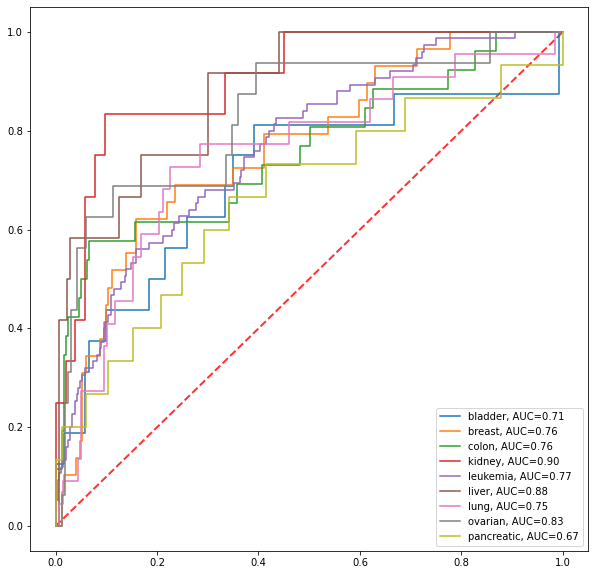

In [67]:
plt.figure(0, figsize=(10,10)).clf()
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=0.8)
plt.plot(fpr,tpr,label="bladder, AUC="+str("%.2f" %auc))
plt.plot(fprB2,tprB2,label="breast, AUC="+str("%.2f" %aucB2))
plt.plot(fprC,tprC,label="colon, AUC="+str("%.2f" %aucC))
plt.plot(fprK,tprK,label="kidney, AUC="+str("%.2f" %aucK))
plt.plot(fprL1,tprL1,label="leukemia, AUC="+str("%.2f" %aucL1))
plt.plot(fprL2,tprL2,label="liver, AUC="+str("%.2f" %aucL2))
plt.plot(fprL3,tprL3,label="lung, AUC="+str("%.2f" %aucL3))
plt.plot(fprO,tprO,label="ovarian, AUC="+str("%.2f" %aucO))
plt.plot(fprP,tprP,label="pancreatic, AUC="+str("%.2f" %aucP))
plt.legend(loc=4)